Jupyter Notebook for Dolphin Network

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler
import skfuzzy as fuzz
from copy import deepcopy
import json
import numpy as np
from scipy.linalg import fractional_matrix_power
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import os

/Users/ashfak/venv-metal/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Import Dolphin Network and feature matrix creation

In [2]:
# Create the graph (example using networkx)
G = nx.read_gml('dolphins.gml')  # Load the Dolphin network if available or replace with appropriate graph loading method
node_names = np.array(list(G.nodes()))
print(node_names)
# Adjacency matrix
A = nx.adjacency_matrix(G).toarray()

# Adding self-loops
A = A + np.eye(G.number_of_nodes())

# Degree matrix
D = np.diag(np.sum(A, axis=1))

# Compute D^-0.5
D_half_norm = fractional_matrix_power(D, -0.5)

# Feature matrix initialization (simple identity matrix in this example)
E = np.eye(G.number_of_nodes())
C = np.eye(G.number_of_nodes())  # This is just a placeholder, replace or modify as per actual features
X = np.concatenate((E, C), axis=1)

# Graph convolution operation
X = D_half_norm.dot(A).dot(D_half_norm).dot(X)

['Beak' 'Beescratch' 'Bumper' 'CCL' 'Cross' 'DN16' 'DN21' 'DN63' 'Double'
 'Feather' 'Fish' 'Five' 'Fork' 'Gallatin' 'Grin' 'Haecksel' 'Hook' 'Jet'
 'Jonah' 'Knit' 'Kringel' 'MN105' 'MN23' 'MN60' 'MN83' 'Mus' 'Notch'
 'Number1' 'Oscar' 'Patchback' 'PL' 'Quasi' 'Ripplefluke' 'Scabs'
 'Shmuddel' 'SMN5' 'SN100' 'SN4' 'SN63' 'SN89' 'SN9' 'SN90' 'SN96'
 'Stripes' 'Thumper' 'Topless' 'TR120' 'TR77' 'TR82' 'TR88' 'TR99'
 'Trigger' 'TSN103' 'TSN83' 'Upbang' 'Vau' 'Wave' 'Web' 'Whitetip' 'Zap'
 'Zig' 'Zipfel']


Define the traditional autoencoder

Kmeans++ with Traditional Auto Encoder

In [3]:
class AE(keras.Model):
    def __init__(self, encoder, decoder, A, **kwargs):
        super(AE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.A = A
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.architecture_loss_tracker = keras.metrics.Mean(
            name="architecture_loss"
        )

    def call(self, inputs):
      x = self.encoder(inputs)
      x = self.decoder(x)
      return x

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.architecture_loss_tracker
        ]
    def predict(self, data):
       z_mean, z_log_var, z = self.encoder(data)
       output = self.decoder(z)
       return output

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z = self.encoder(data)
            reconstruction = self.decoder(z)
            #reconstruction_loss = tf.reduce_mean(
            #    tf.reduce_sum(
            #        keras.losses.mean_absolute_error(data, reconstruction), axis=(1, 2)
            #    )
            #)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data-reconstruction), axis=(1)))
            architecture_loss = tf.reduce_mean(tf.square(self.A - tf.matmul(z,z,transpose_b=True)))
            total_loss = reconstruction_loss + architecture_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.architecture_loss_tracker.update_state(architecture_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "architecture_loss": self.architecture_loss_tracker.result()
        }

In [4]:
#For AE
nFeatures = X.shape[1]
nEmbeddings = 2
nEpochs = 8000
learningRate = 0.001
optimizer = Adam(learningRate)
batchSize = X.shape[0]


2024-04-22 21:19:59.729160: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-22 21:19:59.729293: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-22 21:19:59.729328: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-22 21:19:59.729394: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-22 21:19:59.729429: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
scaler = StandardScaler()
scaledX = scaler.fit_transform(X)

In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

print(nFeatures)
input_encoder = Input(shape=(nFeatures, ))
nNeurons = nFeatures // 2
x = Dense(nNeurons, activation='tanh')(input_encoder)
nNeurons = nNeurons // 2
while(nNeurons >= nEmbeddings * 2):
  x = Dense(nNeurons, activation='tanh')(x)
  nNeurons = nNeurons // 2
z = Dense(nEmbeddings, name="z")(x)

input_decoder = Input(shape=(nEmbeddings, ))
nNeurons = nEmbeddings * 2
x = Dense(nNeurons, activation='tanh')(input_decoder)
nNeurons = nNeurons * 2
while(nNeurons <= nFeatures // 2):
  x = Dense(nNeurons, activation='tanh')(x)
  nNeurons = nNeurons * 2
recon = Dense(nFeatures)(x)
encoder = Model(input_encoder, z, name="encoder")
decoder = Model(input_decoder, recon, name="decoder")
ae = AE(encoder, decoder, A)
ae.compile(optimizer=optimizer)
ae.built = True

124


In [7]:
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 124)            │         4,092 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,832 (18.88 KB)

 Trainable params: 4,832 (18.88 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 124)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 62)             │         7,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │         1,953 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ z (Dense)                       │ (None, 2)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,311 (40.28 KB)

 Trainable params: 10,311 (40.28 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
hist = ae.fit(X, epochs = nEpochs, batch_size=batchSize, verbose = False)

2024-04-22 21:22:19.976695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [10]:
ae.save_weights(os.getcwd()+'/ae_dolphins' + '.weights.h5')
ae.load_weights(os.getcwd()+'/ae_dolphins' + '.weights.h5')

dict_keys(['architecture_loss', 'reconstruction_loss', 'total_loss'])


Text(0, 0.5, 'Architecture loss')

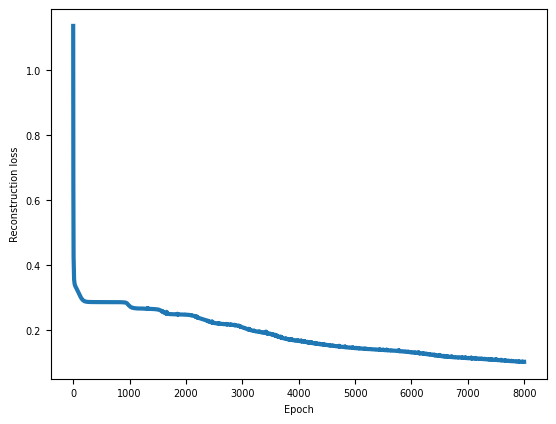

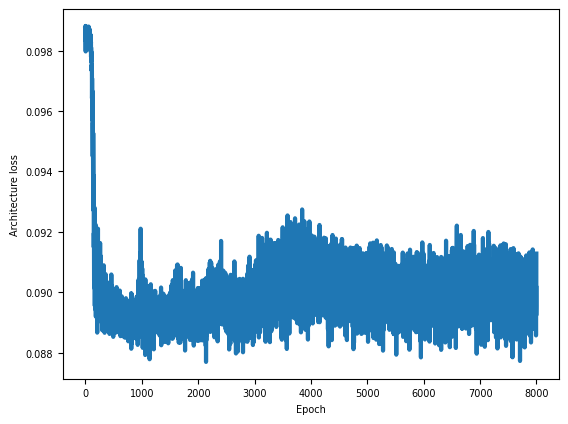

In [20]:
print(hist.history.keys())
x_range = range(len(hist.history['total_loss']))
plt.plot(x_range, hist.history['reconstruction_loss'])
plt.xlabel('Epoch')
plt.ylabel('Reconstruction loss')
plt.figure()
plt.plot(x_range, hist.history['architecture_loss'])
plt.xlabel('Epoch')
plt.ylabel('Architecture loss')

In [58]:
Z = ae.encoder(X)

In [59]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [60]:
max_n = 50
lst_SSE = []
lst_labels = []
lst_centroids = []
lst_silhouette_scores = []
for n_cluster in range(2, max_n + 1):
  kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(Z)
  SSE = 0
  for i in range(len(Z)):
    C = np.asarray(kmeans.cluster_centers_[kmeans.labels_[i]])
    loc = np.asarray(Z[i])
    SSE += np.sum(np.square(C - loc))
  lst_SSE.append(SSE)
  lst_labels.append(kmeans.labels_)
  lst_centroids.append(kmeans.cluster_centers_)
  score = silhouette_score(Z, kmeans.labels_)
  lst_silhouette_scores.append(score)

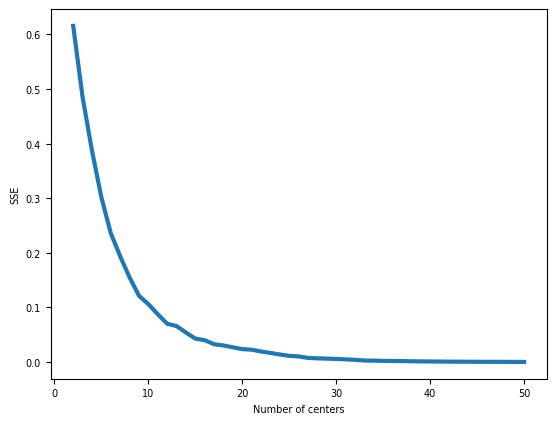

In [62]:
xRange = [i for i in range(2,max_n + 1)]
plt.plot(xRange, lst_SSE)
plt.xlabel('Number of centers')
plt.ylabel('SSE')
plt.savefig('/Users/ashfak/Downloads/dolphin-figs/'+ f'ae_sse_cmeans.png', dpi=450, bbox_inches = "tight")

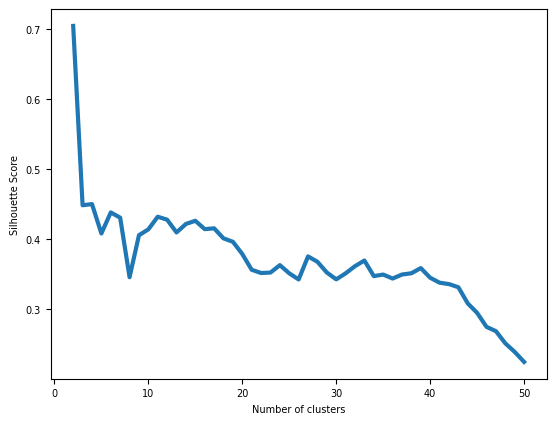

In [63]:
# Silhouette Score
xRange = [i for i in range(2,max_n + 1)]
plt.plot(xRange, lst_silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.savefig('/Users/ashfak/Downloads/dolphin-figs/'+ f'ae_sils_kmeans.png', dpi=450, bbox_inches = "tight")

In [64]:
n_clusters = 5
inx = n_clusters-2
members = [[] for _ in range(n_clusters)]
members_classes = [[] for _ in range(n_clusters)]
for i in range(len(lst_labels[inx])):
  members[lst_labels[inx][i]].append(i)
  members_classes[lst_labels[inx][i]].append(node_names[i])

In [65]:
file = open(os.getcwd()  + '/list_clusters_dol/'+'_'+ str(n_clusters) + '_no_redundancy_ae_kmeans.json','w')
file.write(json.dumps(members_classes))
file.close()

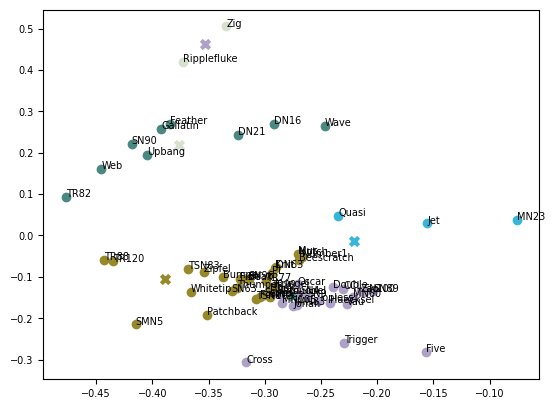

In [80]:
import random
y = [[] for i in range(n_clusters)]
x = [[] for i in range(n_clusters)]
centroid_y = []
centroid_x = []
hexadecimal_alphabets = '0123456789ABCDEF'
colors = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in range(6)]) for i in range(n_clusters)]
# colors = ['red','green','blue','purple','orange', 'black', 'gray', 'pink', 'yellow', 'navy']
for i in range(n_clusters):
  for j in members[i]:
    y[i].append(Z[j][1])
    x[i].append(Z[j][0])
  centroid_y.append(lst_centroids[n_clusters-2][i][1])
  centroid_x.append(lst_centroids[n_clusters-2][i][0])
# plt.axis('off')
plt.rcParams.update({'font.size': 7, 'lines.linewidth':3})
for i in range(n_clusters):
  plt.scatter([centroid_x[i]], [centroid_y[i]], color=colors[i],marker='x')
  plt.scatter(x[i], y[i], color=colors[i])
  for j in range(len(x[i])):
    plt.text(x[i][j], y[i][j], members_classes[i][j])
plt.savefig('/Users/ashfak/Downloads/dolphin-figs/'+ f'ae_kmeans_no_redundency.png', dpi=450, bbox_inches = "tight")

C means with traditional auto encoder

In [69]:
maxNCenters = 50
losses = []
memberships = []
centroids = []
silhouette_scores = []
for nCenters in range(2,maxNCenters+1):
  cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
          Z.numpy().T, nCenters, 2, error=0.005, maxiter=1000, init=None)
  memberships.append(u)
  centroids.append(cntr)
  sse = 0
  for i in range(len(Z)):
    zLoc = np.asarray(Z[i])
    for j in range(nCenters):
      cLoc = np.asarray(cntr[j])
      sse += u[j][i] * np.sum(np.square(zLoc - cLoc))
  losses.append(sse)
  hard_clusters = np.argmax(u, axis=0)
  silhouette_scores.append(silhouette_score(Z, hard_clusters))

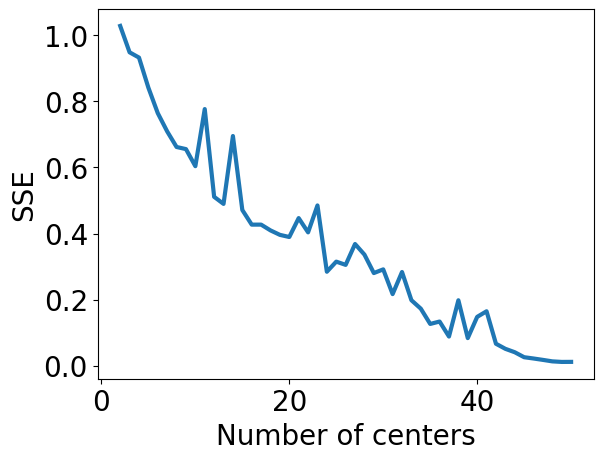

In [81]:
x_range = [i for i in range(2,maxNCenters+1)]
#plt.figure(figsize=(12, 6))
plt.rcParams.update({'font.size': 20, 'lines.linewidth':3})
plt.plot(x_range,losses)
plt.xlabel('Number of centers')
plt.ylabel('SSE')
plt.savefig('/Users/ashfak/Downloads/dolphin-figs/'+ f'ae_cmeans_sse.png', dpi=450, bbox_inches = "tight")
#plt.xticks(x_range, rotation=45)
#plt.grid(True)

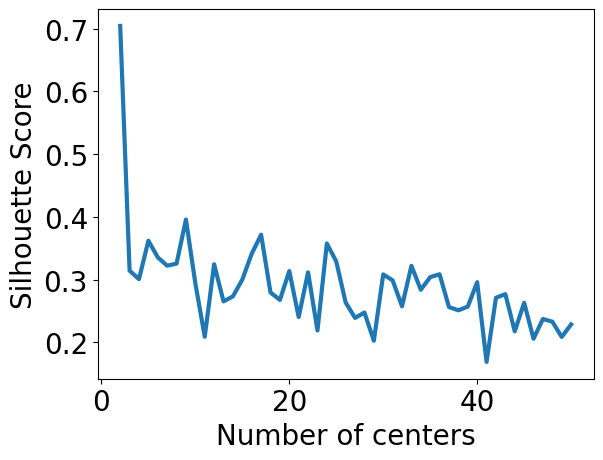

In [78]:
x_range = [i for i in range(2,maxNCenters+1)]
#plt.figure(figsize=(12, 6))
plt.rcParams.update({'font.size': 20, 'lines.linewidth':3})
plt.plot(x_range,silhouette_scores)
plt.xlabel('Number of centers')
plt.ylabel('Silhouette Score')
plt.savefig('/Users/ashfak/Downloads/dolphin-figs/'+ f'ae_cmeans_sils.png', dpi=450, bbox_inches = "tight")
#plt.xticks(x_range, rotation=45)
#plt.grid(True)

In [74]:
n_clusters = 5
members = [[] for i in range(n_clusters)]
members_classes = [[] for i in range(n_clusters)]
clusters = np.argmax(memberships[n_clusters-2].T, axis = 1)
for i in range(len(clusters)):
  members[clusters[i]].append(i)
  members_classes[clusters[i]].append(node_names[i])

In [56]:
file = open(os.getcwd()  + '/list_clusters_dol/'+'_'+ str(n_clusters) + '_no_redundancy_ae_cmeans.json','w')
file.write(json.dumps(members_classes))
file.close()

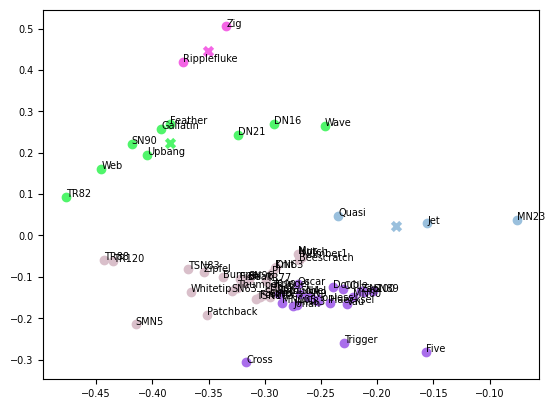

In [79]:
y = [[] for i in range(n_clusters)]
x = [[] for i in range(n_clusters)]
centroid_y = []
centroid_x = []
hexadecimal_alphabets = '0123456789ABCDEF'
colors = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in range(6)]) for i in range(n_clusters)]
# colors = ['red','green','blue','purple','orange', 'black', 'gray', 'pink', 'yellow', 'navy']
for i in range(n_clusters):
  for j in members[i]:
    y[i].append(Z[j][1])
    x[i].append(Z[j][0])
  centroid_y.append(centroids[n_clusters-2][i][1])
  centroid_x.append(centroids[n_clusters-2][i][0])
# plt.axis('off')
plt.rcParams.update({'font.size': 7, 'lines.linewidth':3})
for i in range(n_clusters):
  plt.scatter([centroid_x[i]], [centroid_y[i]], color=colors[i],marker='x')
  plt.scatter(x[i], y[i], color=colors[i])
  for j in range(len(x[i])):
    plt.text(x[i][j], y[i][j], members_classes[i][j])
plt.savefig('/Users/ashfak/Downloads/dolphin-figs/' + f'_scatter_no_redundancy_ae_cmeans.png', dpi=450, bbox_inches = "tight")